In [1]:
# - Outlook for multiple classes: for multi-class prediction 
#     use softmax but for multi-label prediction use sigmoid
# - Use aws deep learning instance: 
#     https://docs.aws.amazon.com/dlami/latest/devguide/keras-mxnet.html
# - Use t-SNE to visualize the word embeddings
# - Similarity search by using learned embeddings, i.e. 
#     https://blog.insightdatascience.com/the-unreasonable-effectiveness-of-deep-learning-representations-4ce83fc663cf
#     (especially Spotify Annoy Index)
# - Test out 1d-conv layers vs. stacked LSTM
# - in order to handle arbitrary length input: 
#     (1) remove input_length from embedding layer,
#     (2) batch wise apply pad_sequences to training input

# TODO:
# - multi-label, unbalanced dataset: use class_wheight, etc. (https://blog.mimacom.com/text-classification/, https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras)
# - use CNN before or after LSTM layers
# - use other metrics to assess model quality (recall, confusion matrix, etc.)
# - implement http://www.aclweb.org/anthology/W18-0913
# - implement http://www.aclweb.org/anthology/C16-1229
# - overall good overview: https://realpython.com/python-keras-text-classification/

In [82]:
from keras.datasets import imdb
from keras.preprocessing import sequence 
from keras.layers import LSTM, Embedding, Dense, Flatten, Bidirectional, Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import get_file
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
import numpy as np
from nltk.corpus import reuters
from sklearn.preprocessing import MultiLabelBinarizer

MAX_NUM_WORDS = 5000
MAX_SEQUENCE_LEN = 500

In [3]:
#categs = sorted([(cat, len(reuters.fileids(categories=cat))) for cat in reuters.categories()], key=lambda x: -x[1])
#categs[:10]

In [4]:
#top_categories = [cat for cat, _ in categs[2:7]]
#fileids = reuters.fileids(categories=top_categories)
fileids = reuters.fileids()
fileids_test = np.array([fid for fid in fileids if fid.startswith("test")])
fileids_train = np.array([fid for fid in fileids if fid.startswith("train")])

In [5]:
mlb = MultiLabelBinarizer()
mlb.fit(reuters.categories(fid) for fid in fileids_train)
y_train = mlb.transform(reuters.categories(fid) for fid in fileids_train)
y_test = mlb.transform(reuters.categories(fid) for fid in fileids_test)

In [6]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(reuters.raw(fid) for fid in fileids)
X_train = tokenizer.texts_to_sequences(reuters.raw(fid) for fid in fileids_train)
X_test = tokenizer.texts_to_sequences(reuters.raw(fid) for fid in fileids_test)

In [7]:
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LEN)

In [22]:
# get glove coeff matrix
embeddings_index = {}
fname = get_file("glove.6B.100d.txt", "http://nlp.stanford.edu/data/glove.6B.zip", extract=True)
with open(fname, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

# prepare pre-learned embedding matrix
embdedding_dim = 100
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embdedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [157]:
glove_embedding = Embedding(num_words, embdedding_dim, input_length=MAX_SEQUENCE_LEN,
                            embeddings_initializer=Constant(embedding_matrix), trainable=True)

# Build the model 
model = Sequential()
model.add(glove_embedding)
model.add(Dropout(0.1))
model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Dropout(0.1))
#model.add(Conv1D(128, 5, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Dropout(0.1))
#model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.1))
#model.add(Dropout(0.1))
#model.add(LSTM(100, return_sequences=True))
#model.add(LSTM(100))
#model.add(Dropout(0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='relu', name='fc'))
model.add(Dropout(0.1))
model.add(Dense(mlb.classes_.shape[0], activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 500, 100)          500100    
_________________________________________________________________
dropout_76 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 496, 128)          64128     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               66048     
_________________________________________________________________
dropout_78 (Dropout)         (None, 512)               0         
__________

In [158]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=True)

Train on 6992 samples, validate on 777 samples
Epoch 1/10
6992/6992 [==============================] - 107s 15ms/step - loss: 0.0509 - acc: 0.9863 - val_loss: 0.0268 - val_acc: 0.9924
Epoch 2/10
6992/6992 [==============================] - 100s 14ms/step - loss: 0.0234 - acc: 0.9934 - val_loss: 0.0170 - val_acc: 0.9946
Epoch 3/10
6992/6992 [==============================] - 109s 16ms/step - loss: 0.0171 - acc: 0.9948 - val_loss: 0.0136 - val_acc: 0.9956
Epoch 4/10
6992/6992 [==============================] - 101s 14ms/step - loss: 0.0135 - acc: 0.9956 - val_loss: 0.0127 - val_acc: 0.9960
Epoch 5/10
6992/6992 [==============================] - 98s 14ms/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0113 - val_acc: 0.9964
Epoch 6/10
6992/6992 [==============================] - 95s 14ms/step - loss: 0.0091 - acc: 0.9970 - val_loss: 0.0109 - val_acc: 0.9964
Epoch 7/10
6992/6992 [==============================] - 97s 14ms/step - loss: 0.0079 - acc: 0.9973 - val_loss: 0.0112 - val_acc: 0.99

In [159]:
y_test_pred = model.predict(X_test, verbose=1)

3019/3019 [==============================] - 12s 4ms/step


In [160]:
from sklearn.metrics import classification_report
PRED_THRESHOLD = 0.5
print(classification_report(y_test, y_test_pred>PRED_THRESHOLD, target_names=mlb.classes_))

                 precision    recall  f1-score   support

            acq       0.96      0.96      0.96       719
           alum       1.00      0.57      0.72        23
         barley       0.80      0.57      0.67        14
            bop       0.76      0.53      0.63        30
        carcass       0.91      0.56      0.69        18
     castor-oil       0.00      0.00      0.00         1
          cocoa       0.95      1.00      0.97        18
        coconut       0.00      0.00      0.00         2
    coconut-oil       0.00      0.00      0.00         3
         coffee       1.00      0.96      0.98        28
         copper       0.89      0.89      0.89        18
     copra-cake       0.00      0.00      0.00         1
           corn       0.80      0.95      0.87        56
         cotton       1.00      0.30      0.46        20
     cotton-oil       0.00      0.00      0.00         2
            cpi       0.92      0.43      0.59        28
            cpu       0.00    

/Users/tdiggelm/checkout/total_nn/.py/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/tdiggelm/checkout/total_nn/.py/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [13]:
#####################################################################################################################
############################################# TESTING ###############################################################
#####################################################################################################################

In [162]:
from keras.models import Model
model_vec = Model(model.input, model.get_layer(name="fc").output)
vecs = model_vec.predict(X_test, verbose=1)

from sklearn.preprocessing import normalize
vecs_norm = normalize(vecs)

3019/3019 [==============================] - 11s 4ms/step


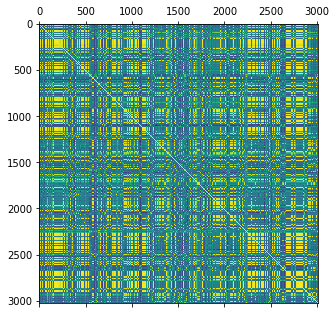

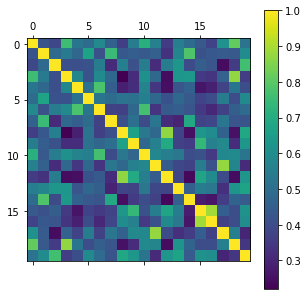

In [163]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sim_matrix = vecs_norm.dot(vecs_norm.T)

plt.figure(figsize=(5,5))
plt.matshow(sim_matrix, fignum=1)
plt.show()

plt.figure(figsize=(5,5))
plt.matshow(sim_matrix[:20, :20], fignum=1)
plt.colorbar()
plt.show()

In [174]:
search_text = """Taiwan announced plans for another round
  of import tariff cuts on 862 foreign goods shortly before trade
  talks with Washington which officials described as a move to
  help balance trade with the United States."""

#search_text = reuters.raw(fileids_test[0])

print("INPUT:")
print(search_text)

search_text_vec = model_vec.predict(
    sequence.pad_sequences(tokenizer.texts_to_sequences([search_text]), maxlen=MAX_SEQUENCE_LEN))
search_text_vec = normalize(search_text_vec)

print("RESULT:")
sim_scores = search_text_vec[0].dot(vecs_norm.T)
sorted_indices = np.argsort(-sim_scores)
topn = 5
result_scores = sim_scores[sorted_indices[:topn]]
result_tags = [reuters.categories(fid) for fid in fileids_test[sorted_indices[:topn]]]
result_texts = [reuters.raw(fid) for fid in fileids_test[sorted_indices[:topn]]]
for idx in range(topn):
    print(">>> %d: [%0.2f]: %s" % (idx+1, result_scores[idx], ",".join(result_tags[idx])))
    print(result_texts[idx])
    print()

INPUT:
Taiwan announced plans for another round
  of import tariff cuts on 862 foreign goods shortly before trade
  talks with Washington which officials described as a move to
  help balance trade with the United States.
RESULT:
>>> 1: [0.96]: trade
CIVIL SERVICE STRIKE DELAYS U.K. TRADE FIGURES
  Civil service industrial action started
  early this month will delay the publication of May's U.K.
  Overseas trade figures, which had been due out next Thursday, a
  Trade and Industry Department statement said.
      A department spokesman said the figures will probably be
  put back by about a month. The June trade figures, due in late
  July, will also be delayed, he added.
  



>>> 2: [0.96]: trade
REAGAN TO ANNOUNCE DECISION ON JAPAN SANCTIONS
  President Reagan today is to
  announce a decision on tough new tariffs on Japanese exports to
  retaliate for what he calls Japan's failure to end its unfair
  practices in semiconductor trade.
      The 100 pct tariffs are to be imposed on 